## Analysis notebook for Thompson Sampling of PETase strains

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz
import ipywidgets
from matplotlib import cm, pyplot
import numpy
import os
import pandas
import pathlib
import pickle

try:
    import pymc3
except:
    import pymc as pymc3

import calibr8
import cutisplit
import pyrff
import retl
import robotools
import scipy

import run_analysis

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%load_ext watermark
%watermark --iversions

cutisplit : 0.2.0
pyrff     : 2.0.1
retl      : 0.3.1
pandas    : 1.3.4
pymc      : 4.0.0b2
scipy     : 1.7.2
numpy     : 1.20.3
arviz     : 0.11.4
ipywidgets: 7.6.5
matplotlib: 3.5.0
robotools : 1.1.0
calibr8   : 6.2.1



Error while reading the files. Repetition 3 does not exist and loop will be exited
Error while reading the files. Repetition 3 does not exist and loop will be exited
Error while reading the files. Repetition 3 does not exist and loop will be exited


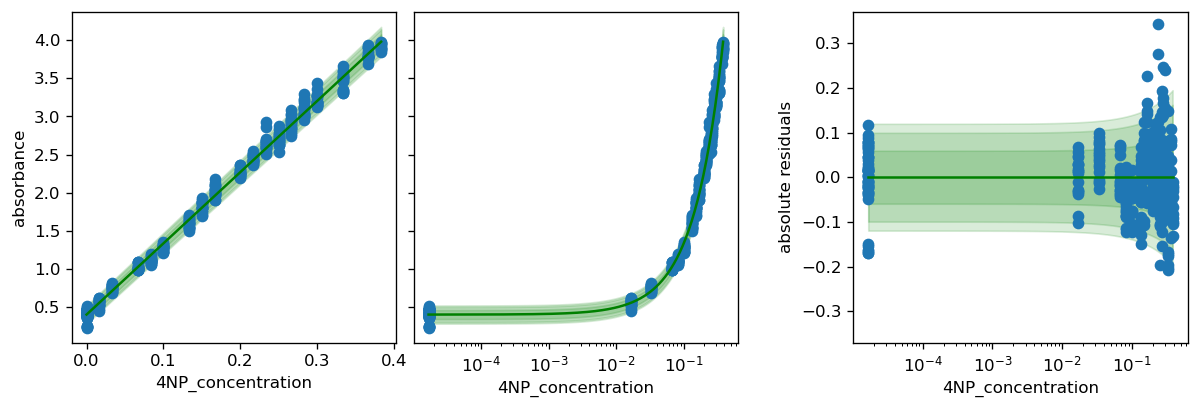

In [4]:
RUN_ID = "C4PZHQ"
resultpath = f'{RUN_ID}_Results' 
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel.load(rf"{resultpath}\{RUN_ID}_cm_nitrophenol.json")
calibr8.plot_model(cm_nitrophenol)


df_inputs, df_kinetics = run_analysis.read_rounds([
    "BWNZ99", "BZP1XQ", "C4PZHQ"
])

## Creating the Model

In [5]:
model = cutisplit.LongFormModel(
    df_inputs,
    df_kinetics=df_kinetics,
    cm_nitrophenol=cm_nitrophenol,
)
# the shapes of the dataset are encoded in the "coords" of the underlying PyMC model:
model.summary()

c:\users\helleckes\repos\pymc\pymc\data.py:640: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(


strain              (24,)	AbnA30, AmyE30, AprE30, …, YwmC30
culture_id          (72,)	BWNZ99_A02, BWNZ99_A04, BWNZ99_A05, …, C4PZHQ_F07
kinetic_id          (288,)	BWNZ99_1_B01, BWNZ99_1_B02, BWNZ99_1_B03, …, C4PZHQ_2_G12
column_id           (12,)	1, 2, 3, …, 12
cutinase_cycle      (30,)	0, 1, 2, …, 29


The PyMC3 model can be visualized as a graph:

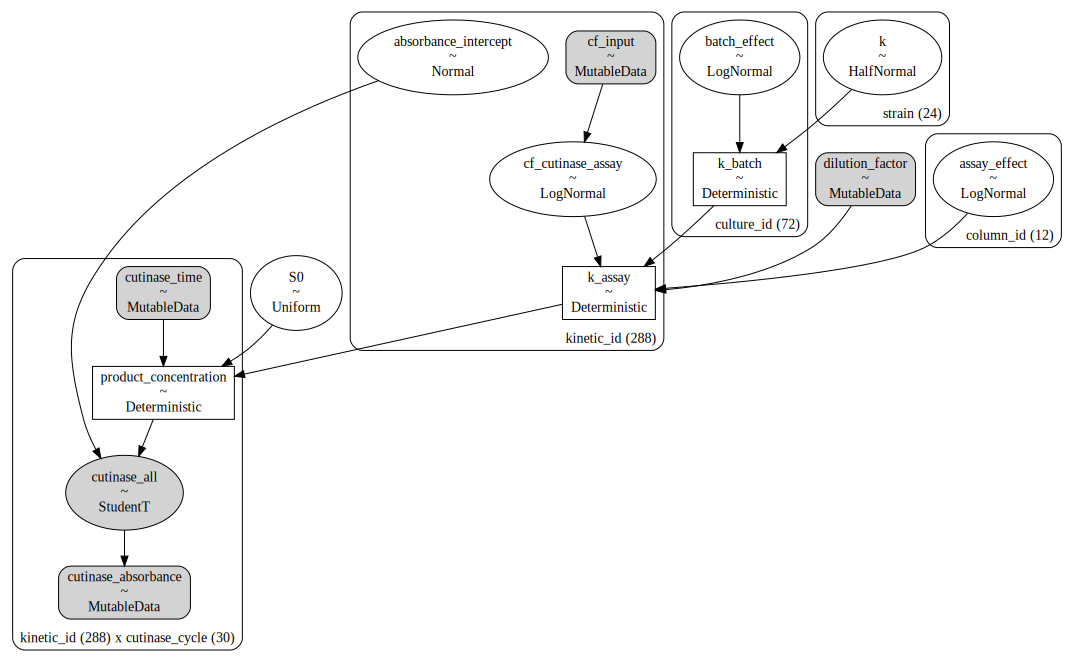

In [6]:
pymc3.model_to_graphviz(model.pmodel)

In [7]:
with model.pmodel:
    idata = pymc3.sample(return_inferencedata=True, target_accept=0.9)
idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cf_cutinase_assay, k, batch_effect, assay_effect, S0, absorbance_intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 639 seconds.
The number of effective samples is smaller than 25% for some parameters.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

The result should be saved such that the analysis can run in another notebook.

In [8]:
idata.to_netcdf(fr"{resultpath}\{RUN_ID}_PE-H35_investigate_column_effect.nc")

'CB4MNH_Results\\CB4MNH_PE-H35_investigate_column_effect.nc'

Execute the next cell in case you want to reload saved data

In [7]:
idata = arviz.from_netcdf(fr"{resultpath}\{RUN_ID}_result_columneffect.nc")
idata2 = arviz.from_netcdf(fr"BZP1XQ_Results\BZP1XQ_result_hierarchical_greaterSD.nc")

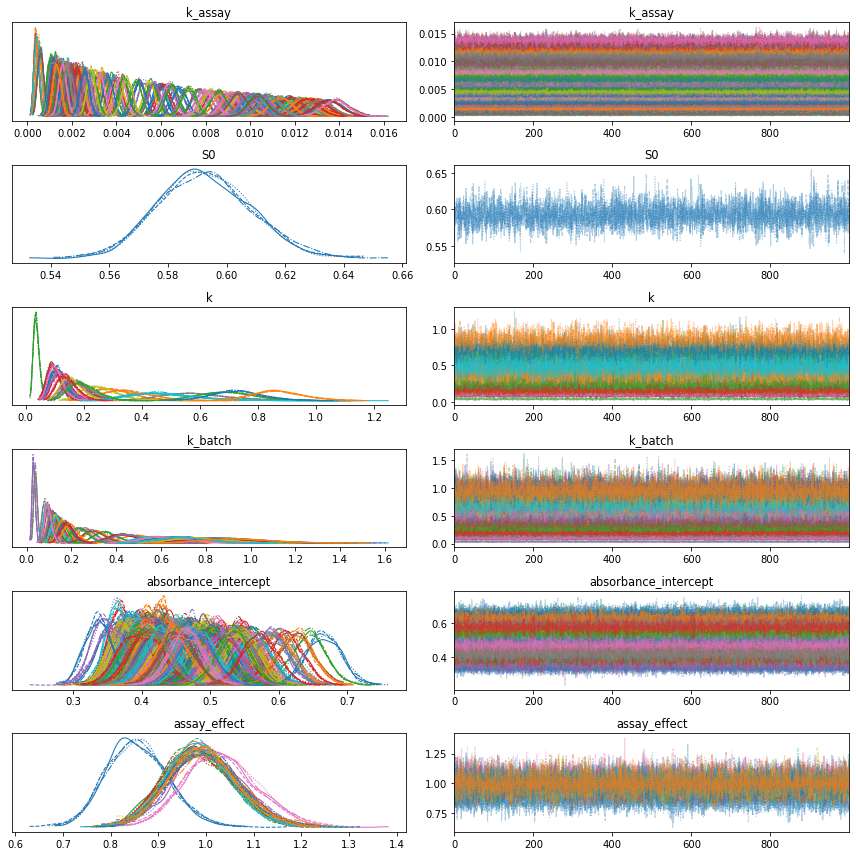

In [64]:
arviz.plot_trace(idata, var_names=[
    "k_assay", "S0", "k", "k_batch", "absorbance_intercept", "assay_effect"
]);
pyplot.tight_layout()
# The left subplots show the posterior probability density.
# The right subplots show the MCMC. If they look like random noise everything is fine.
# The linestyle corresponds to independent MCMC chains - they should come to the same result.

C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_6.0.5\lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (144) is smaller than the number of resulting pair plots with these variables, generating only a 16x16 grid
  warnings.warn(


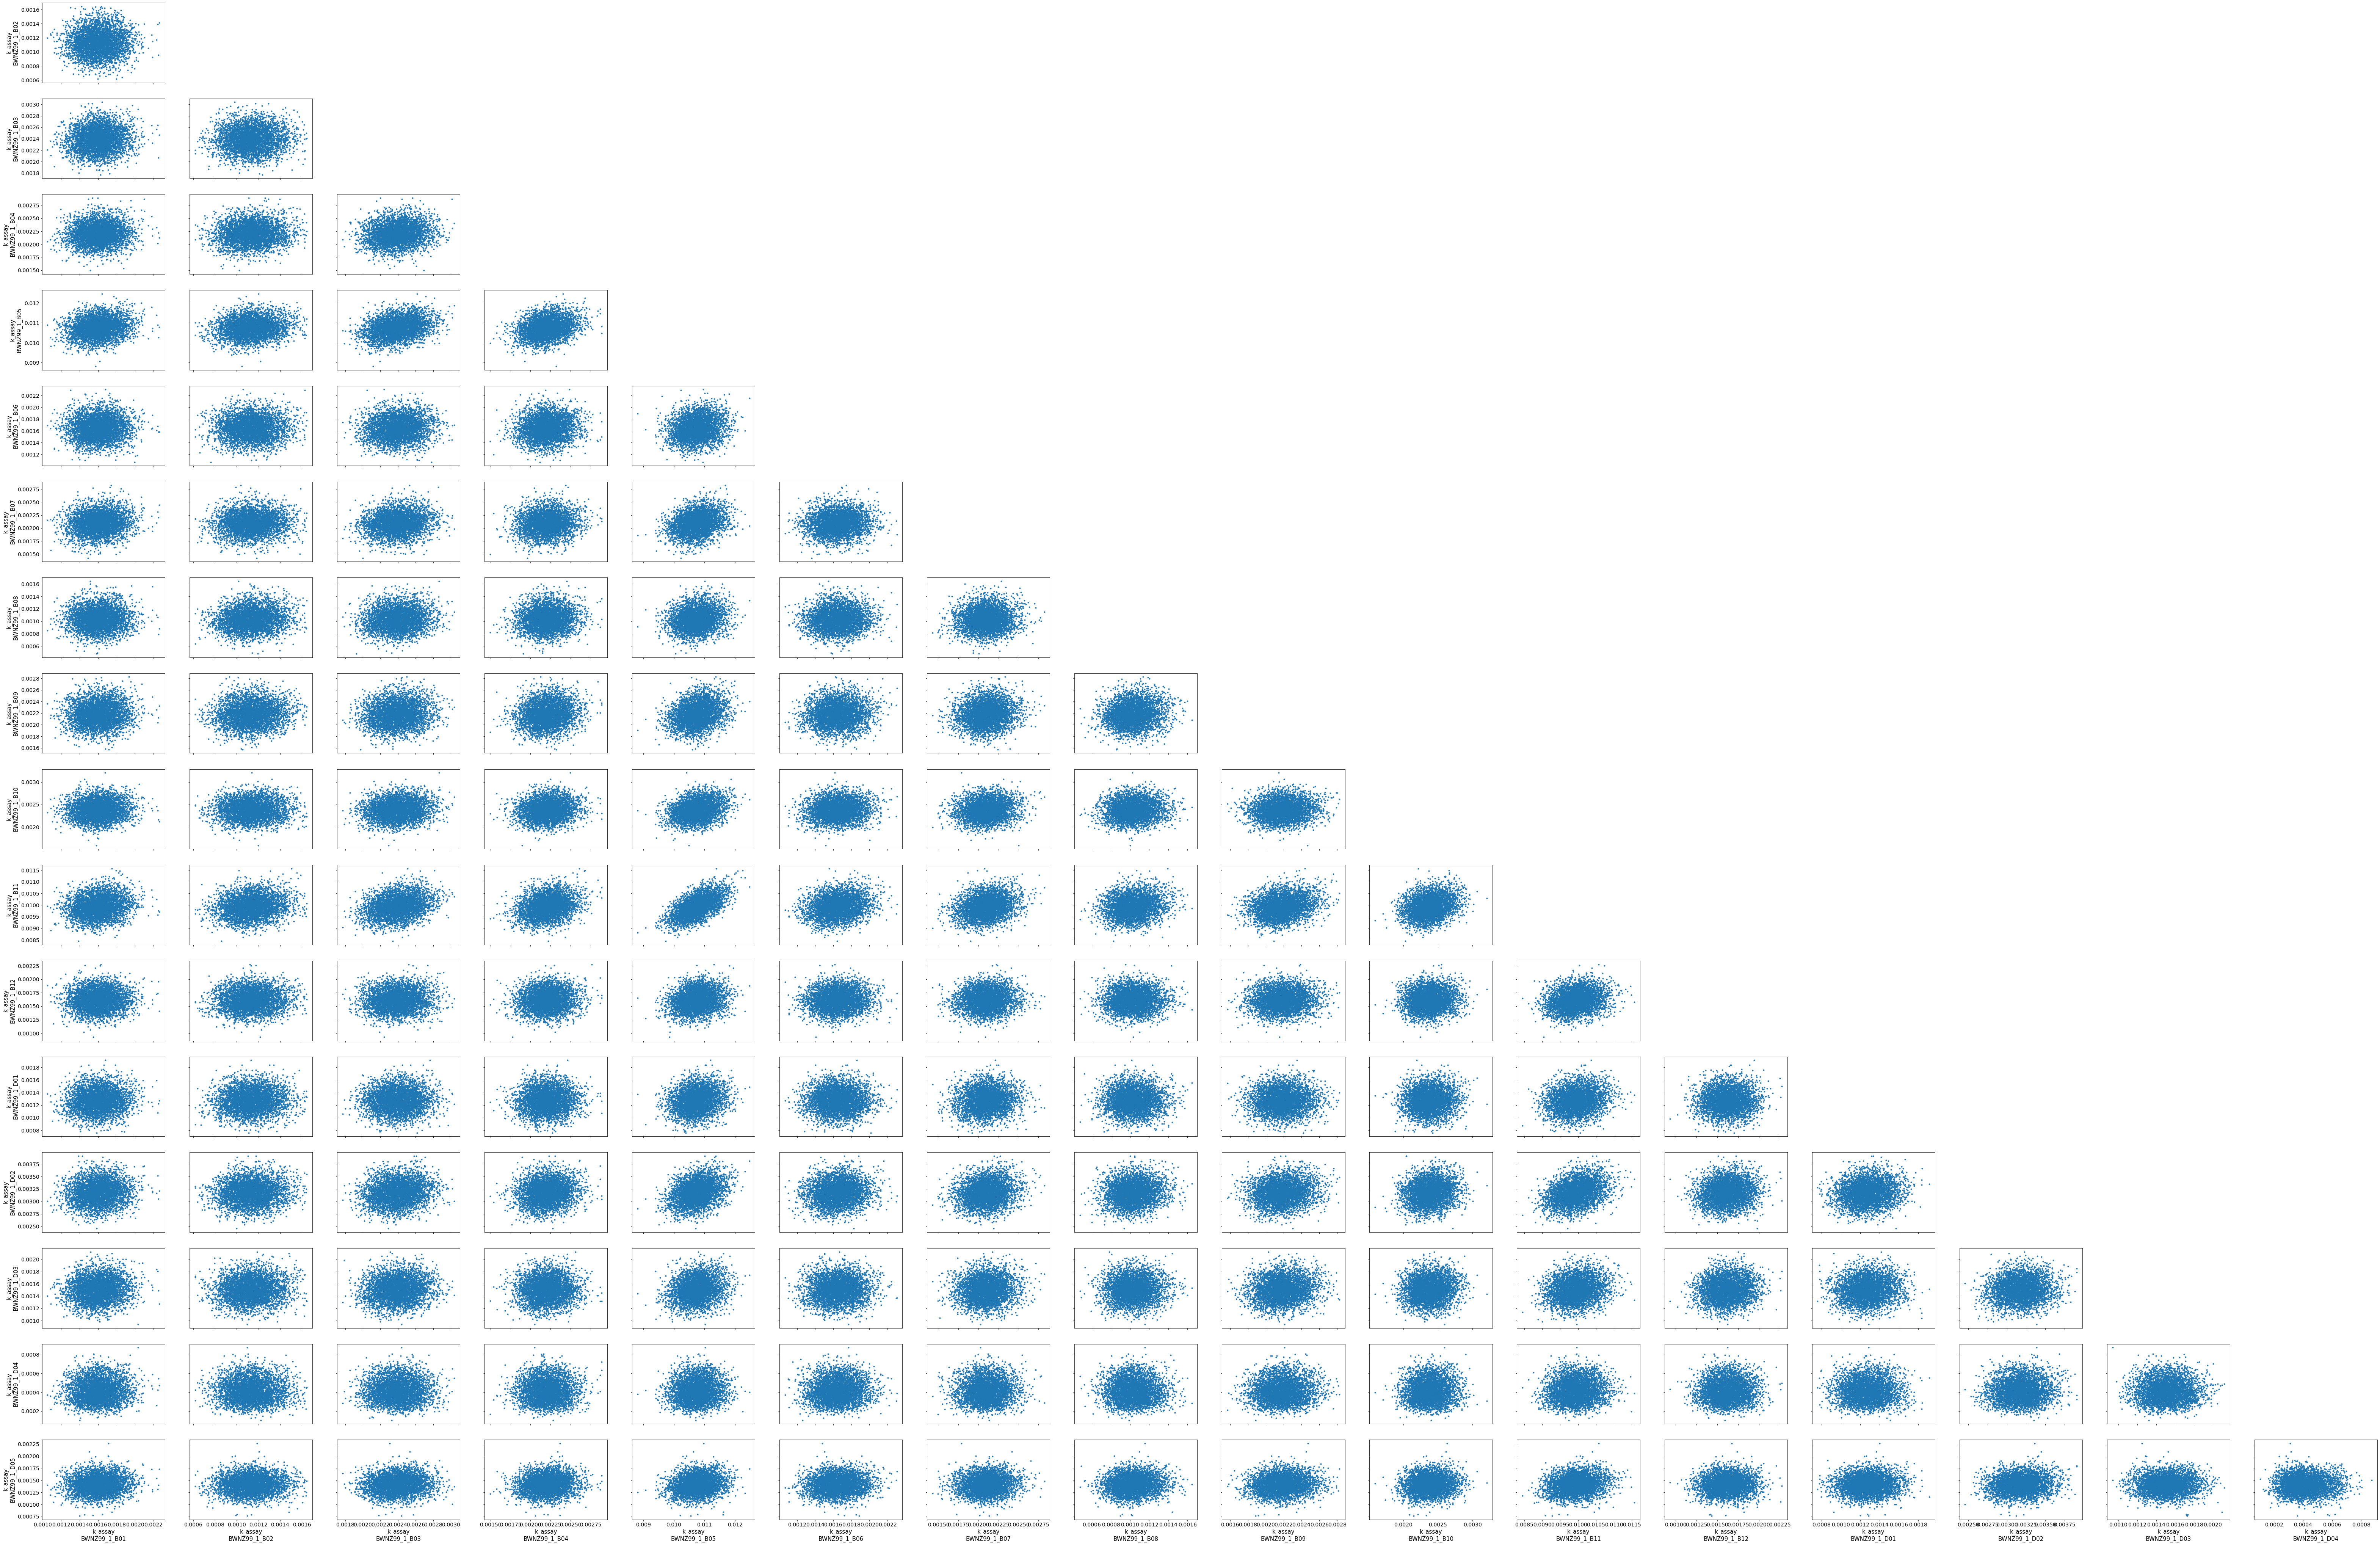

In [65]:
arviz.rcParams['plot.max_subplots'] = 144
arviz.plot_pair(idata, var_names=[
    "k_assay", 
    "k", "k_batch", "S0", 
    "absorbance_intercept"
]);

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

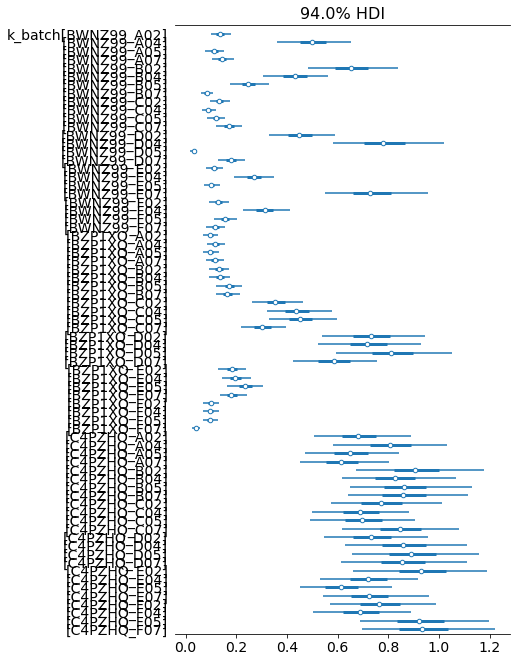

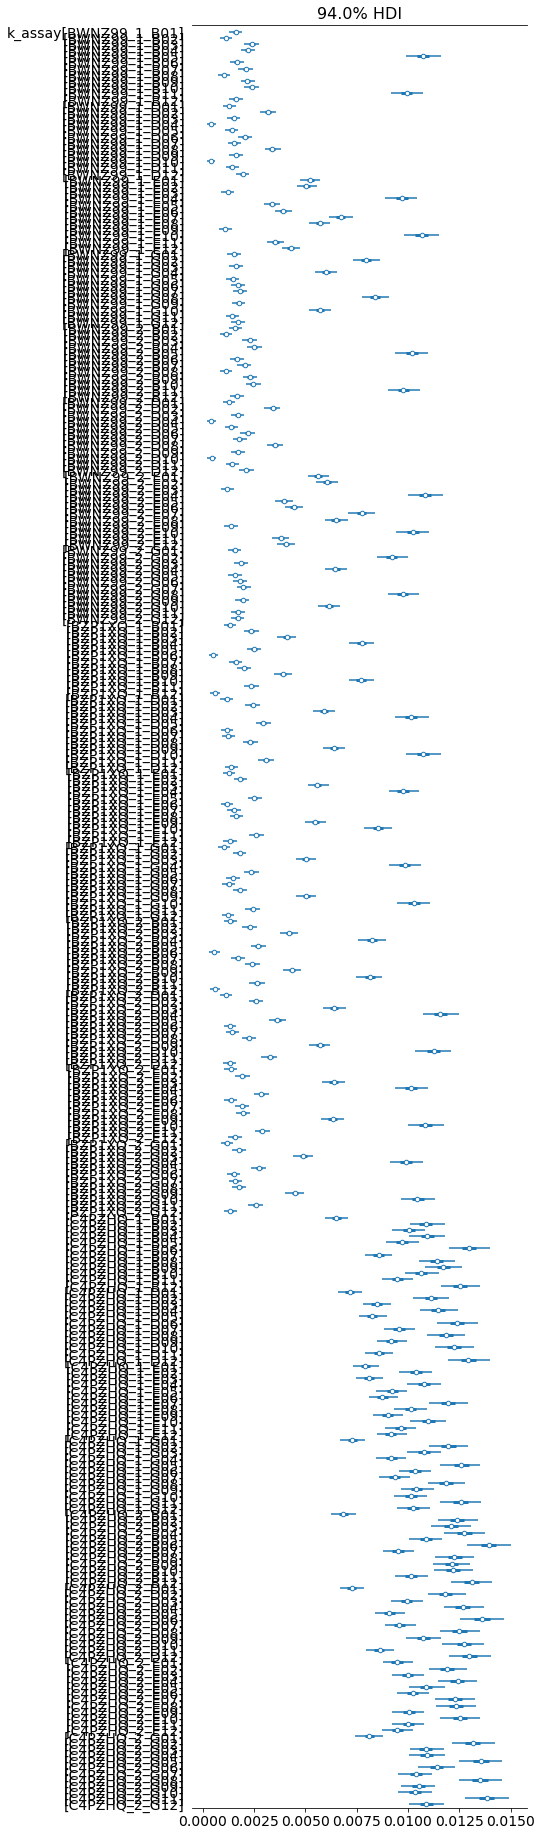

In [66]:
arviz.plot_forest(idata, var_names=["k_batch"], combined=True)
arviz.plot_forest(idata, var_names=["k_assay"], combined=True)

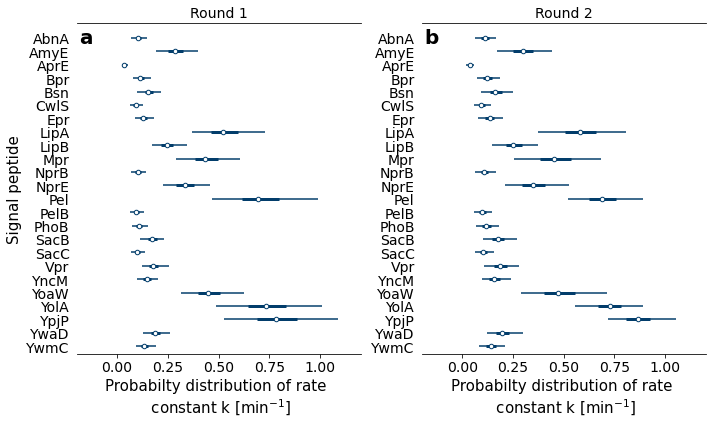

In [45]:
import string
fig, axs = pyplot.subplots(figsize=(10,6), ncols=2)
for i, (idat, ax) in enumerate(zip([idata2, idata], axs.flatten())):
    arviz.plot_forest(idat, var_names=["k"], combined=True, ax=ax, colors=["#023D6B"])
    ax.set_xlabel("Probabilty distribution of rate \n constant k [min$^{-1}$]", size=15)
    strains = numpy.unique([
        strain[:-2]
        for strain in df_inputs.strain.values
])
    ax.set_yticklabels(strains[::-1])
    ax.set_xlim(-0.2, 1.2)
    ax.text(0.01, 0.94, string.ascii_lowercase[i], transform=ax.transAxes, 
            size=20, weight='bold')
    ax.set_title(f"Round {i+1}", size=14)
axs[0].set_ylabel("Signal peptide", size=15)
pyplot.tight_layout()
pyplot.savefig(fr"{resultpath}\{RUN_ID}_PE-H_kprobs_round2.png", dpi=200)

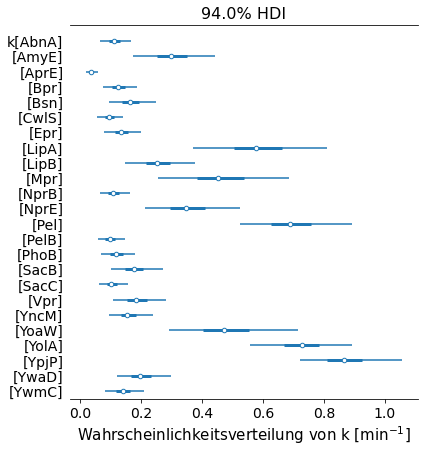

In [67]:
arviz.plot_forest(idata, var_names=["k"], combined=True)
pyplot.xlabel("Wahrscheinlichkeitsverteilung von k [min$^{-1}$]", size=15)
pyplot.tight_layout()
#pyplot.savefig(fr"{resultpath}\{RUN_ID}_PE-H_30degree_kprobs(round2).png", dpi=200)

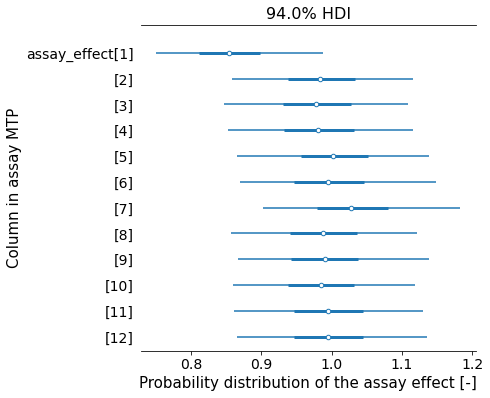

In [68]:
fig, ax = pyplot.subplots(figsize=(6, 6))
arviz.plot_forest(idata, var_names=["assay_effect"], combined=True, ax=ax)
pyplot.xlabel("Probability distribution of the assay effect [-]", size=15)
pyplot.ylabel("Column in assay MTP", size=15)
yticks = ax.get_yticks()
#ax.set_yticks(yticks, labels=numpy.arange(1,13))
#pyplot.tight_layout()
#pyplot.savefig(fr"{resultpath}\{RUN_ID}_PE-H_30degree_assay-effect(round1).png", dpi=200)

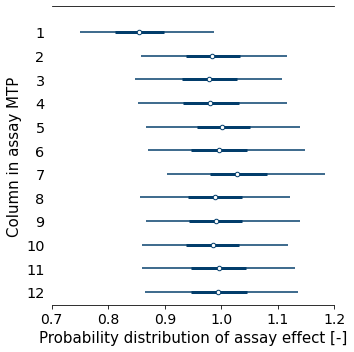

In [69]:
fig, ax = pyplot.subplots(figsize=(5, 5))
arviz.plot_forest(idata, var_names=["assay_effect"], combined=True, ax=ax, colors=["#023d6b"])
pyplot.xlabel("Probability distribution of assay effect [-]", size=15)
pyplot.ylabel("Column in assay MTP", size=15)
yticks = ax.get_yticks()
ax.set_yticks(yticks, labels=numpy.arange(1,13)[::-1], size=14.5)
ax.set_title("")
ax.set_xlim(0.7,1.2)
pyplot.tight_layout()
#pyplot.savefig(fr"{resultpath}\{RUN_ID}_PE-H3035_assay-effect_round1.png", dpi=200)

In [9]:
posterior = idata.posterior.stack(sample=("chain", "draw"))
posterior2 = idata2.posterior.stack(sample=("chain", "draw"))

In [10]:
strains = numpy.unique(df_inputs.strain.values)
numpy.random.seed(20220302)
selected_strains = pyrff.sample_batch(
    posterior.k.values,
    ids=strains,
    batch_size=24,
    correlated=True
)
numpy.unique(selected_strains, return_counts=True)

(array(['Pel30', 'YolA30', 'YpjP30'], dtype='<U6'),
 array([ 2,  1, 21], dtype=int64))

In [11]:
selected_strains_shuffled = numpy.copy(selected_strains)
numpy.random.shuffle(selected_strains_shuffled)
wells = [f"{l}{n:02d}" for n in [1,8] for l in "ABCDEF" ] 
inoculation_dict = {
    well: strain 
    for well, strain in zip(wells, selected_strains_shuffled)
}
inoculation_dict

{'A01': 'YolA30',
 'B01': 'Pel30',
 'C01': 'YpjP30',
 'D01': 'YpjP30',
 'E01': 'YpjP30',
 'F01': 'YpjP30',
 'A08': 'YpjP30',
 'B08': 'YpjP30',
 'C08': 'YpjP30',
 'D08': 'YpjP30',
 'E08': 'YpjP30',
 'F08': 'YpjP30'}

In [12]:
probs = pyrff.sampling_probabilities(
    posterior.k.values,
    correlated=True
)
probs2 = pyrff.sampling_probabilities(
    posterior2.k.values,
    correlated=True
)

In [13]:
old_strains= [
    strain.split("3")[0]
    for strain in numpy.unique(df_inputs.strain.values)
]

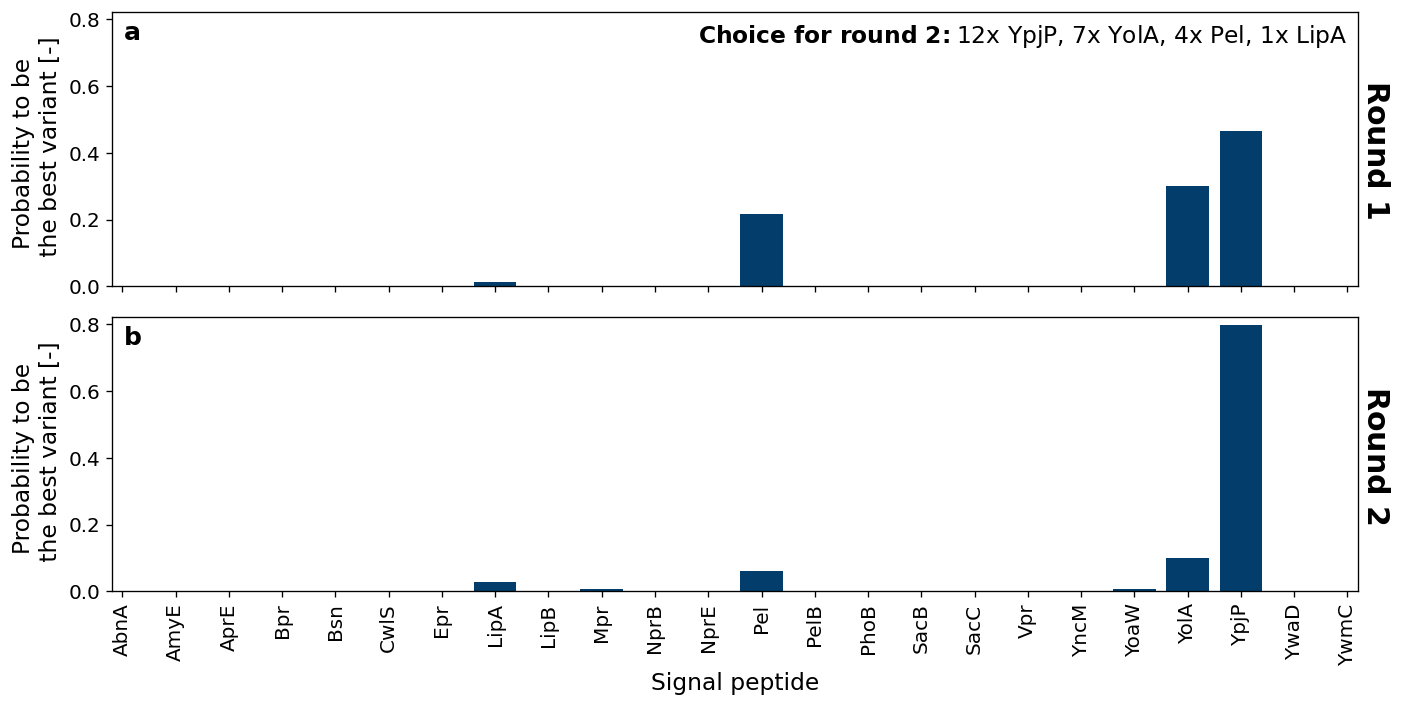

In [26]:
fig, axs = pyplot.subplots(figsize=(12,6), dpi=120, nrows=2, sharex=True)
ax= axs[0]
ax.bar(x=numpy.arange(len(probs)), height=probs2, color="#023D6B")
ax.set_xlim(-0.2,23.2)
ax.set_xticks(numpy.arange(len(probs)), labels=old_strains, rotation=90)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel("Probability to be \n the best variant [-]", size=14)
ax.set_ylim(0,0.82)
ax.annotate(xy=(10.8, 0.73), text=r"$\bf{Choice \ for \ round \ 2\!:}$" + "12x YpjP, 7x YolA, 4x Pel, 1x LipA", size=14)
ax.annotate(xy=(23.25, 0.22), text=r"$\bf{Round \ 1}$", size=18, annotation_clip=False, rotation=270)
ax = axs[1]
ax.set_xlim(-0.2,23.2)
ax.set_xticks(numpy.arange(len(probs2)), labels=old_strains, rotation=90)
ax.bar(x=numpy.arange(len(probs2)), height=probs, color="#023D6B")
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel("Probability to be \n the best variant [-]", size=14)
ax.set_ylim(0,0.82)
ax.set_xlabel("Signal peptide", size=14)
ax.annotate(xy=(23.25, 0.22), text=r"$\bf{Round \ 2}$", size=18, annotation_clip=False, rotation=270)
for i, ax in enumerate(axs.flatten()):
    import string
    ax.text(0.01, 0.9, string.ascii_lowercase[i], transform=ax.transAxes, size=15, weight='bold')
pyplot.tight_layout()

pyplot.savefig(fr"{resultpath}\{RUN_ID}_PE-H_30TS_probs_both_rounds_Paper.png", dpi=200)

C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_6.0.5\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


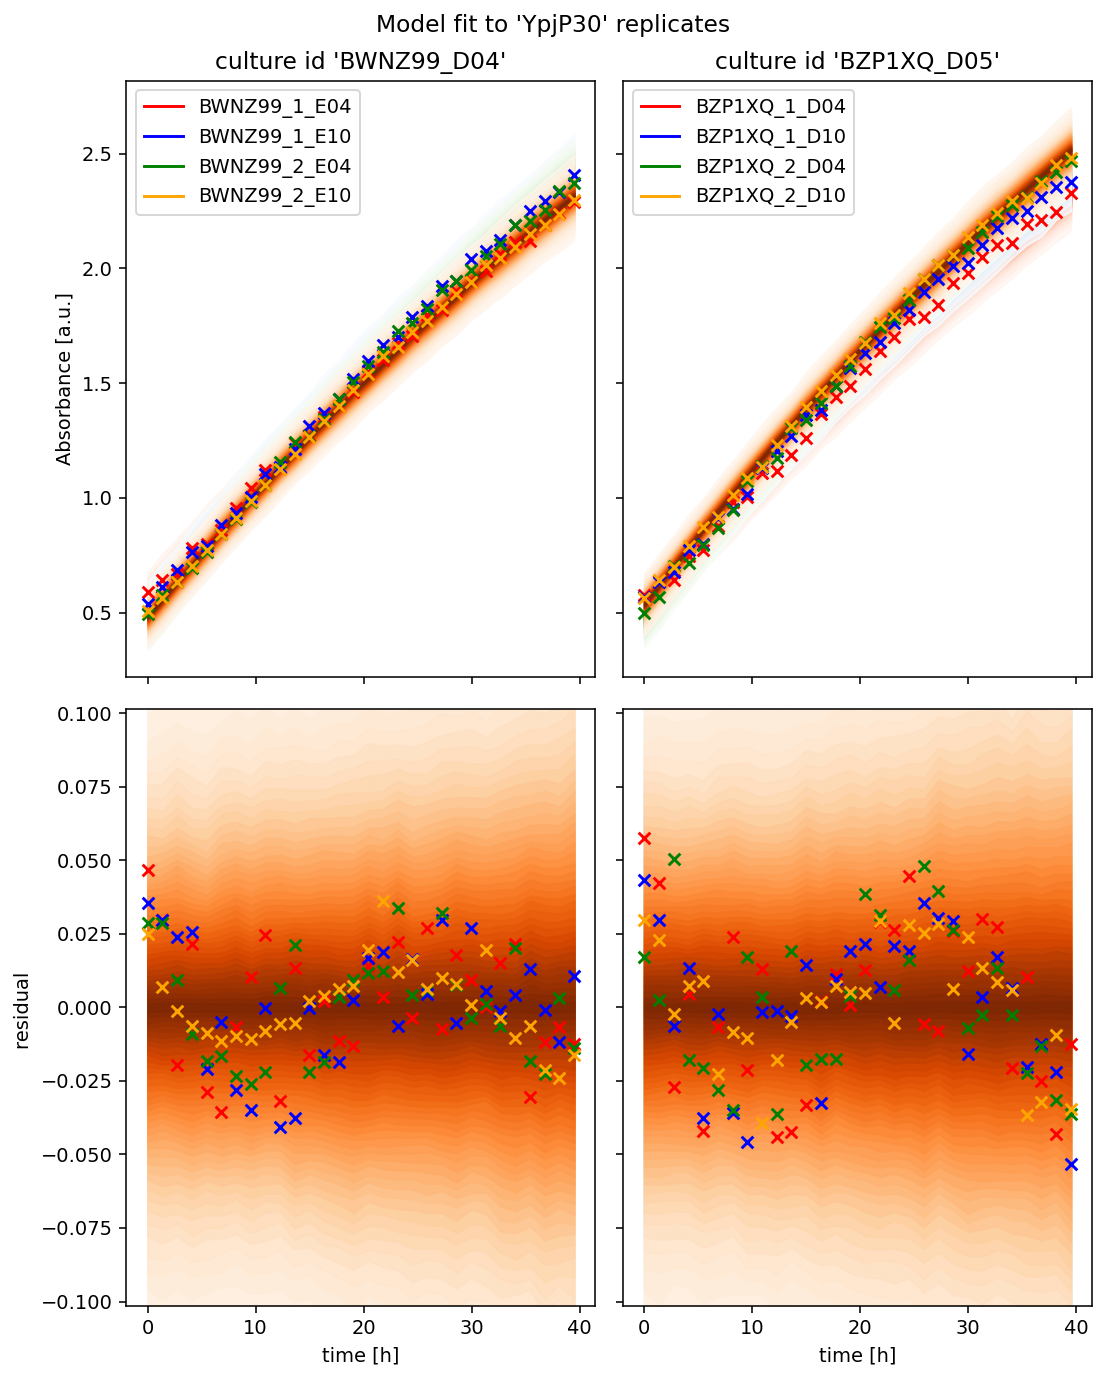

In [19]:
#for strain in posterior.strains.values:
strain="YpjP30"
culture_ids = df_inputs[df_inputs.strain==strain].index.to_list()
fig, axs = pyplot.subplots(
    dpi=140,
    figsize=(
        4*len(culture_ids), 10),
    ncols=len(culture_ids),
    nrows=2,
    sharey="row",
    sharex="col",
    squeeze=False,
)
for c, cid in enumerate(culture_ids):
    df = df_kinetics[df_kinetics.culture_id==cid]
    kinetic_ids = df.index
    residual_ptp = 0
    for r, (kid, (color, cmap)) in enumerate(zip(kinetic_ids, [
        ("red", "Reds"),
        ("blue", "Blues"),
        ("green", "Greens"),
        ("orange", "Oranges"),
    ])):


        # and the actual absorbance
        absorbance = idata.constant_data.cutinase_absorbance.sel(kinetic_id=kid)
        #print(color, kid, cid)
        
        axs[0,c].scatter(
            idata.constant_data.cutinase_time.values[0,:],
            absorbance,
            marker="x",
            color=color,
            zorder=10
        )
        theta = [
            posterior.absorbance_intercept.sel(kinetic_id=kid).values
        ] + list(cm_nitrophenol.theta_fitted[1:])
        loc, scale, df = cm_nitrophenol.predict_dependent(
            posterior.product_concentration.sel(kinetic_id=kid).values,
            theta=theta
            
        )
        pp_samples = scipy.stats.t.rvs(loc=loc, scale=scale, df=df)

        pymc3.gp.util.plot_gp_dist(
            ax=axs[0,c],
            samples=pp_samples.T,
            x=idata.constant_data.cutinase_time.values[0,:],
            palette=cmap,
            plot_samples=False,
        )
        
        #residuals
        median = numpy.median(pp_samples, axis=1)
        residuals = absorbance.values - median
        residual_ptp = max(residual_ptp, numpy.ptp(residuals))

        pymc3.gp.util.plot_gp_dist(
            ax=axs[1, c],
            samples=(pp_samples - median[:,None]).T,
            x=idata.constant_data.cutinase_time.values[0,:],
            plot_samples=False,
            palette=cmap
        )
        axs[1, c].scatter(
            idata.constant_data.cutinase_time.values[0,:], residuals, marker="x", color=color, zorder=10
        )
        axs[0, c].plot([], [], color=color, label=kid)
    # formatting
    axs[0, c].set_title(f"culture id '{cid}'")
    axs[1, c].set_xlabel("time [h]") 
    axs[0, c].legend()

axs[0, 0].set_ylabel(
    "Absorbance [a.u.]"
)
axs[1, 0].set_ylim(-residual_ptp, residual_ptp)
axs[1, 0].set_ylabel("residual ")
fig.suptitle(
    f"Model fit to '{strain}' replicates"
)
fig.tight_layout()